In [0]:
import numpy as np
import matplotlib.pyplot as plt

# 01.다층 신경망

In [0]:
class MultiClassNetwork:

  def __init__(self, units = 10, batch_size = 32, learning_rate = 0.1, l1 = 0, l2 = 0):
    self.units = units                # 은닉층 뉴런 개수
    self.batch_size = batch_size      # 배치 크기
    self.w1 = None                    # 은닉층의 가중치
    self.b1 = None                    # 은닉층의 절편
    self.w2 = None                    # 출력층의 가중치
    self.b2 = None                    # 출력층의 절편
    self.a1 = None                    # 은닉층의 활성화 출력
    self.losses = []                  # 훈련 손실
    self.val_losses = []              # 검증 손실
    self.lr = learning_rate           # 학습률
    self.l1 = l1                      # L1 손실 하이퍼파라미터
    self.l2 = l2                      # L2 손실 하이퍼 파라미터

  def forpass(self, x):
    z1 = np.dot(x, self.w1) + self.b1                   # 첫 번째 층의 선형식을 계산
    self.a1 = self.sigmoid(z1)                          # 활성화 함수 적용
    z2 = np.dot(self.a1, self.w2) + self.b2             # 두 번째 층의 선형식을 계산
    return z2

  def backprop(self, x, err):
    m = len(x)    # 샘플 개수
    # 출력층의 가중치와 절편에 대한 그레이디언트를 계산
    w2_grad = np.dot(self.a1.T, err) / m
    b2_grad = np.sum(err) / m
    # 시그모이드 함수까지 그레이디언트 계산
    err_to_hidden = np.dot(err, self.w2.T) * self.a1 * (1 - self.a1)
    # 은닉층의 가중치와 절편에 대한 그레이디언트 계산
    w1_grad = np.dot(x.T, err_to_hidden) / m
    b1_grad = np.sum(err_to_hidden, axis = 0) / m
    return w1_grad, b1_grad, w2_grad, b2_grad

  def sigmoid(self, z):
    a = 1 / (1 + np.exp(-z))   # 시그모이드 계산
    return a

  def softmax(self, z):
    # 소프트맥스 함수
    exp_z = np.exp(z)
    return exp_z / np.sum(exp_z, axis = 1).reshape(-1, 1)
  
  def init_weights(self, n_features, n_classes):
    self.w1 = np.random.normal(0, 1, (n_features, self.units))    # (특성 개수, 은닉층 크기)
    self.b1 = np.zeros(self.units)                                # 은닉층의 크기
    self.w2 = np.random.normal(0, 1, (self.units, n_classes))     # (은닉층의 크기, 클래스의 개수)
    self.b2  = np.zeros(n_classes)

  def fit(self, x, y, epochs = 100, x_val = None, y_val = None):
    np.random.seed(42)
    self.init_weights(x.shape[1], y.shape[1])       # 은닉층과 출력층의 가중치 초기화
    # epochs만큼 반복
    for i in range(epochs):
      loss = 0
      print('.', end = '')
      # 제너레이터 함수에서 반환한 미니 배치를 순환
      for x_batch, y_batch in self.gen_batch(x, y):
        a = self.training(x_batch, y_batch)
        # 안전한 로그 계산을 위한 클리핑
        a = np.clip(a, 1e-10, 1-1e-10)
        # 로그 손실과 규제 손실을 더하여 리스트에 추가
        loss += np.sum(-y_batch * np.log(a))
      self.losses.append((loss + self.reg_loss()) / len(x))
      # 검증 세트에 대한 손실을 계산
      self.update_val_loss(x_val, y_val)

  # 미니 배치 제너레이터 함수
  def gen_batch(self, x, y):
    length = len(x)
    bins = length // self.batch_size      # 미니 배치 횟수
    if length % self.batch_size:
      bins += 1                           # 나누어 떨어지지 않을 때
    indexes = np.random.permutation(np.arange(len(x)))     # 인덱스 셔플
    x = x[indexes]
    y = y[indexes]
    for i in range(bins):
      start = self.batch_size * i
      end = self.batch_size * (i + 1)
      yield x[start:end], y[start:end]    # batch_size만큼 슬라이싱하여 반환

  def training(self, x, y):
    m = len(x)              # 샘플 개수 저장
    z = self.forpass(x)     # 정방향 계산 수행
    a = self.softmax(z)     # 활성화 함수 적용
    err = -(y - a)          # 오차 계산
    #오차를 역전파 하여 그레이디언트 계산
    w1_grad, b1_grad, w2_grad, b2_grad = self.backprop(x, err)
    # 그레이디언트에서 페널티 항의 미분값을 뻄
    w1_grad += (self.l1 * np.sign(self.w1) + self.l2 * self.w1) / m
    w2_grad += (self.l1 * np.sign(self.w2) + self.l2 * self.w2) / m
    # 은닉층의 가중치와 절편을 업데이트
    self.w1 -= self.lr * w1_grad
    self.b1 -= self.lr * b1_grad
    # 출력층의 가중치와 절편을 업데이트
    self.w2 -= self.lr * w2_grad
    self.b2 -= self.lr * b2_grad
    return a

  def predict(self, x):
    z = self.forpass(x)                 # 정방향 계산 수행
    return np.argmax(z, axis = 1)       # 가장 큰 값의 인덱스를 반환

  def score(self, x, y):
    # 예측과 타깃 열 벡터를 비교하여 True의 비율을 반환
    return np.mean(self.predict(x) == np.argmax(y, axis = 1))

  def reg_loss(self):
    # 은닉층과 출력층의 가중치에 규제를 적용
    return self.l1 * (np.sum(np.abs(self.w1)) + np.sum(np.abs(self.w2))) + \
           self.l2 / 2 * (np.sum(self.w1**2) + np.sum(self.w2**2))
    
  def update_val_loss(self, x_al, y_val):
    z = self.forpass(x_val)             # 정방향 계산 수행
    a = self.softmax(z)                 # 활성화 함수 적용
    a = np.clip(a, 1e-10, 1-1e-10)      # 출력값을 클리핑
    # 크로스 엔트로피 손실과 규제 손실을 더하여 리스트에 추가
    val_loss = np.sum(-y_val * np.log(a))
    self.val_losses.append((val_loss + self.reg_loss()) / len(y_val))

패션 MINIST 데이터 불러오기

In [0]:
# ! pip install tensorflow_gpu==2.0.0-rc1

데이터 임포트

In [0]:
import tensorflow as tf
tf.__version__

'2.0.0-rc1'

데이터 세트 불러오기

In [0]:
(x_train_all, y_train_all), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


훈련 세트 크기 확인

In [0]:
print(x_train_all.shape, y_train_all.shape)

(60000, 28, 28) (60000,)


샘플 이미지 확인

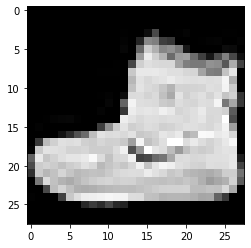

In [0]:
plt.imshow(x_train_all[0], cmap = 'gray')
plt.show()

타깃 내용, 의미 확인

In [0]:
print(y_train_all[:10])

[9 0 0 3 0 2 7 2 5 5]


In [0]:
class_names = ['티셔츠/윗도리', '바지', '스웨터', '드레스', '코트함', '샌들', '셔츠', '스니커즈', '가방', '앵클부츠']

In [0]:
print(class_names[y_train_all[0]])

앵클부츠


In [0]:
np.bincount(y_train_all)

array([6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000])

데이터 나누기

In [0]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train_all, y_train_all, stratify = y_train_all, test_size = 0.2, random_state = 42)

In [0]:
np.bincount(y_train)

array([4800, 4800, 4800, 4800, 4800, 4800, 4800, 4800, 4800, 4800])

In [0]:
np.bincount(y_val)

array([1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200])

입력 데이터 정규화

In [0]:
x_train = x_train / 255
x_val = x_val / 255

데이터 세트 배열 차원 변경 (3차원 --> 2차원)

In [0]:
x_train = x_train.reshape(-1, 784)
x_val = x_val.reshape(-1, 784)
print(x_train.shape, x_val.shape)

타깃 데이터 배열로 변환

원-핫 인코딩

In [0]:
y_train_encoded = tf.keras.utils.to_categorical(y_train)
y_val_encoded = tf.keras.utils.to_categorical(y_val)
print(y_train_encoded.shape, y_val_encoded.shape)

(48000, 10) (12000, 10)


모듈 훈련

In [0]:
fc = MultiClassNetwork(units = 100, batch_size = 256)
fc.fit(x_train, y_train_encoded, x_val = x_val, y_val = y_val_encoded, epochs = 40)

........................................

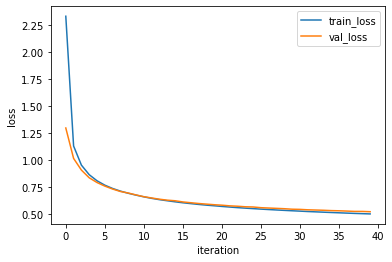

In [0]:
plt.plot(fc.losses)
plt.plot(fc.val_losses)
plt.ylabel('loss')
plt.xlabel('iteration')
plt.legend(['train_loss', 'val_loss'])
plt.show()

In [0]:
fc.score(x_val, y_val_encoded)

0.8150833333333334

# 02.텐서플로, 케라스를 사용한 신경망

In [0]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

모델 제작

In [0]:
model = Sequential()
model.add(Dense(100, activation = 'sigmoid', input_shape = (784,)))
model.add(Dense(10, activation = 'softmax'))
model.compile(optimizer = 'sgd', loss = 'categorical_crossentropy', metrics = ['accuracy'])

모델 훈련

loss, al_loss - 훈련, 검증 세트의 손실

accuracy, val_accuracy - 훈련, 검증 세트의 정확도

In [0]:
history = model.fit(x_train, y_train_encoded, epochs = 40, validation_data = (x_val, y_val_encoded))

Train on 48000 samples, validate on 12000 samples
Epoch 1/40
48000/48000 [==============================] - 5s 108us/sample - loss: 1.4131 - accuracy: 0.6342 - val_loss: 0.9804 - val_accuracy: 0.7247
Epoch 2/40
48000/48000 [==============================] - 4s 89us/sample - loss: 0.8553 - accuracy: 0.7400 - val_loss: 0.7597 - val_accuracy: 0.7588
Epoch 3/40
48000/48000 [==============================] - 4s 90us/sample - loss: 0.7182 - accuracy: 0.7638 - val_loss: 0.6682 - val_accuracy: 0.7783
Epoch 4/40
48000/48000 [==============================] - 4s 87us/sample - loss: 0.6507 - accuracy: 0.7799 - val_loss: 0.6149 - val_accuracy: 0.7929
Epoch 5/40
48000/48000 [==============================] - 4s 87us/sample - loss: 0.6077 - accuracy: 0.7919 - val_loss: 0.5793 - val_accuracy: 0.8018
Epoch 6/40
48000/48000 [==============================] - 4s 86us/sample - loss: 0.5764 - accuracy: 0.8019 - val_loss: 0.5520 - val_accuracy: 0.8087
Epoch 7/40
48000/48000 [==============================]

손실 그래프

<function matplotlib.pyplot.show>

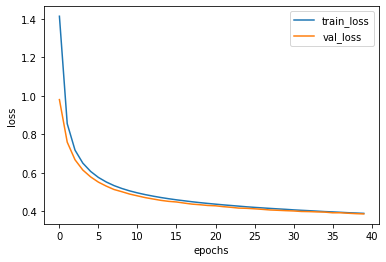

In [0]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train_loss', 'val_loss'])
plt.show

정확도 그래프

<function matplotlib.pyplot.show>

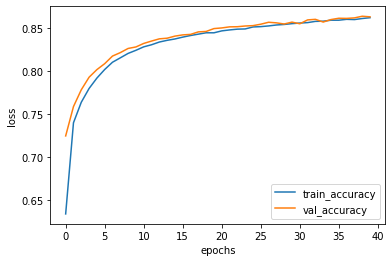

In [0]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show

정확도 계산

In [0]:
loss, accuracy = model.evaluate(x_val, y_val_encoded, verbose = 0)
print(accuracy)

0.86308336
